In [1]:
# just run this cell
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

2024-09-23 13:37:55.348634: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('stock_data.csv')

In [3]:
df.head()

,Price,Adj Close,Adj Close.1,Adj Close.2,Adj Close.3,Adj Close.4,Close,Close.1,Close.2,Close.3,...,Open,Open.1,Open.2,Open.3,Open.4,Volume,Volume.1,Volume.2,Volume.3,Volume.4
0,Ticker,AAPL,AMZN,CVS,GOOG,WMT,AAPL,AMZN,CVS,GOOG,...,AAPL,AMZN,CVS,GOOG,WMT,AAPL,AMZN,CVS,GOOG,WMT
1,Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-02 00:00:00+00:00,184.93821716308594,149.92999267578125,78.46854400634766,139.21810913085938,52.58402633666992,185.63999938964844,149.92999267578125,80.8499984741211,139.55999755859375,...,187.14999389648438,151.5399932861328,78.9000015258789,139.60000610351562,52.41666793823242,82488700,47339400,8780100,20071900,23539800
3,2024-01-03 00:00:00+00:00,183.55348205566406,148.47000122070312,78.4976577758789,140.01614379882812,52.58732604980469,184.25,148.47000122070312,80.87999725341797,140.36000061035156,...,184.22000122070312,149.1999969482422,81.4000015258789,138.60000610351562,53.25666809082031,58414500,49425500,6836200,18974300,18756000
4,2024-01-04 00:00:00+00:00,181.2223358154297,144.57000732421875,78.13856506347656,137.7018280029297,52.078948974609375,181.91000366210938,144.57000732421875,80.51000213623047,138.0399932861328,...,182.14999389648438,145.58999633789062,80.25,139.85000610351562,53.06999969482422,71983600,56039800,22085600,18253300,19282500


In [4]:
# preprocessing
df = df.drop(1)
df = df.rename(columns = {"Price": "Date"})
df = df.reset_index()
df = df.drop(columns = ['index'])
companies = ['AAPL', 'AMZN', 'CVS', 'GOOG', 'WMT']

reshaped_dfs = []
for i, company in enumerate(companies):
    reshaped_df = pd.DataFrame({
        'Date': df['Date'],
        'Company': company,
        'Adj Close': df[f'Adj Close.{i}' if i > 0 else 'Adj Close'],
        'Close': df[f'Close.{i}' if i > 0 else 'Close'],
        'Open': df[f'Open.{i}' if i > 0 else 'Open'],
        'Volume': df[f'Volume.{i}' if i > 0 else 'Volume']
    })
    reshaped_dfs.append(reshaped_df)

# Concatenate the reshaped dataframes into a single dataframe
df = pd.concat(reshaped_dfs, ignore_index=True)
df = df.drop(0)
df = df[df['Date'] != 'Ticker']
df = df.reset_index()
df = df.drop(columns = ['index'])
df.head()

,Date,Company,Adj Close,Close,Open,Volume
0,2024-01-02 00:00:00+00:00,AAPL,184.93821716308594,185.63999938964844,187.14999389648438,82488700
1,2024-01-03 00:00:00+00:00,AAPL,183.55348205566406,184.25,184.22000122070312,58414500
2,2024-01-04 00:00:00+00:00,AAPL,181.2223358154297,181.91000366210938,182.14999389648438,71983600
3,2024-01-05 00:00:00+00:00,AAPL,180.4950714111328,181.17999267578125,181.99000549316406,62303300
4,2024-01-08 00:00:00+00:00,AAPL,184.8585205078125,185.55999755859375,182.08999633789062,59144500


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       880 non-null    object
 1   Company    880 non-null    object
 2   Adj Close  880 non-null    object
 3   Close      880 non-null    object
 4   Open       880 non-null    object
 5   Volume     880 non-null    object
dtypes: object(6)
memory usage: 41.4+ KB


In [6]:
len(df)

880

In [7]:
df['Company'].unique()

array(['AAPL', 'AMZN', 'CVS', 'GOOG', 'WMT'], dtype=object)

In [8]:
df['Date'] = pd.to_datetime(df['Date'])
df['Adj Close'] = df['Adj Close'].astype(float)
df['Close'] = df['Close'].astype(float)
df['Open'] = df['Open'].astype(float)
df['Volume'] = df['Volume'].astype(float)
AAPL = df[df['Company'] == 'AAPL']
AMZN = df[df['Company'] == 'AMZN']
CVS = df[df['Company'] == 'CVS']
GOOG = df[df['Company'] == 'GOOG']
WMT = df[df['Company'] == 'WMT']
company_datasets = [AAPL, AMZN, CVS, GOOG, WMT]

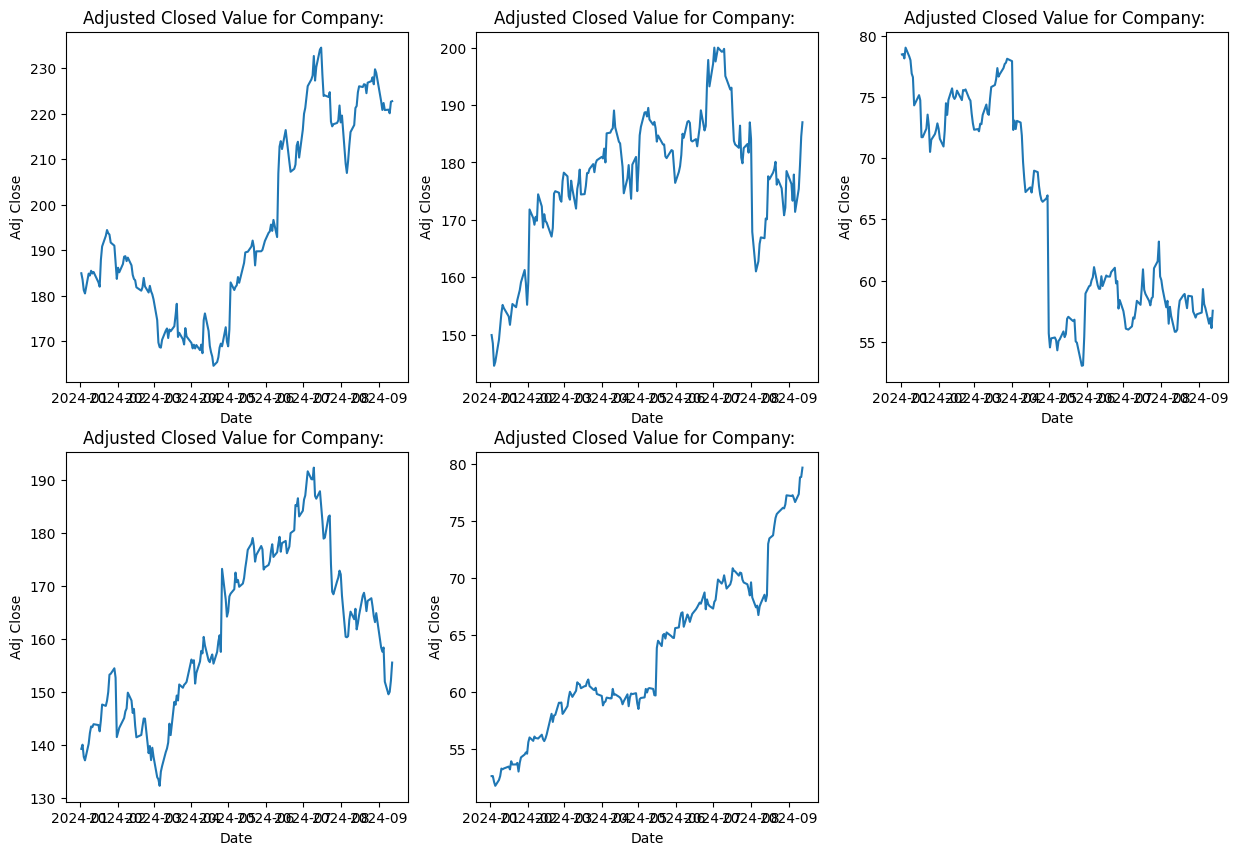

In [9]:
fig = plt.figure(figsize=(15,10))
i = 1
for company in company_datasets:
  plt.subplot(2, 3, i)
  plt.plot(company['Date'], company['Adj Close'], label=company['Company'])
  plt.title(f"Adjusted Closed Value for Company: ")
  plt.xlabel('Date')
  plt.ylabel('Adj Close')
  i += 1
plt.show()

In [11]:
# Preprocessing
# Select the columns to be used as features and target
features = ['Open', 'Adj Close', 'Volume']
target = 'Close'

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[features + [target]])

# Split into X (features) and y (target)
X = scaled_data[:, :-1]  # Use all but the last column ('Close') as features
y = scaled_data[:, -1]   # Use the last column ('Close') as target

# Reshape X to be 3D for LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Define LSTM Model
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=64)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Loss: {loss}')

Epoch 1/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2715
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2140 
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1477 
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0756 
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0324 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0240  
Loss: 0.02374003641307354


In [13]:
# Make predictions and evaluate model
# Make predictions
predictions = model.predict(X_test)

# Reshape predictions and y_test
predictions = predictions.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Calculate R-squared
from sklearn.metrics import r2_score, mean_squared_error

r_squared = r2_score(y_test, predictions)
print(f"R-squared: {r_squared}")

# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
R-squared: 0.7420981654012482
Mean Squared Error (MSE): 0.023740036682431964
Root Mean Squared Error (RMSE): 0.15407802141263355


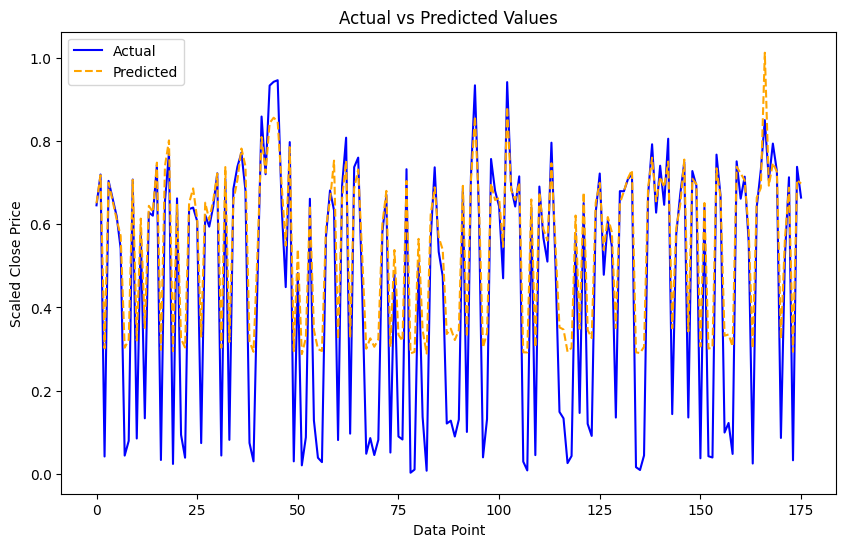

In [14]:
# Plot actual vs predicted variables
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(predictions, label='Predicted', color='orange', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Data Point')
plt.ylabel('Scaled Close Price')
plt.legend()
plt.show()

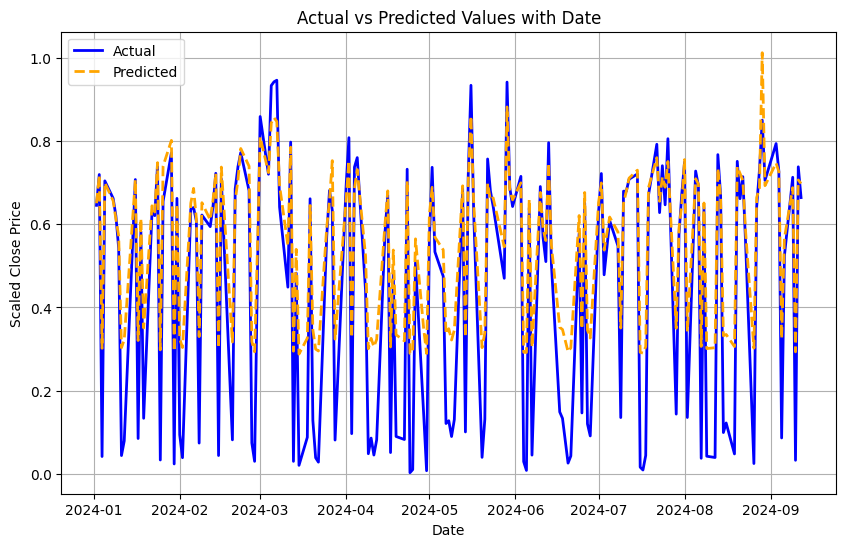

In [16]:
# Plot with dates
# Plot actual vs predicted values with dates
plt.figure(figsize=(10, 6))
plt.plot(df['Date'][len(X_train):], y_test, label='Actual', color='blue', linewidth=2)
plt.plot(df['Date'][len(X_train):], predictions, label='Predicted', color='orange', linewidth=2, linestyle='--')
plt.title('Actual vs Predicted Values with Date')
plt.xlabel('Date')
plt.ylabel('Scaled Close Price')
plt.legend()
plt.grid(True)
plt.show()

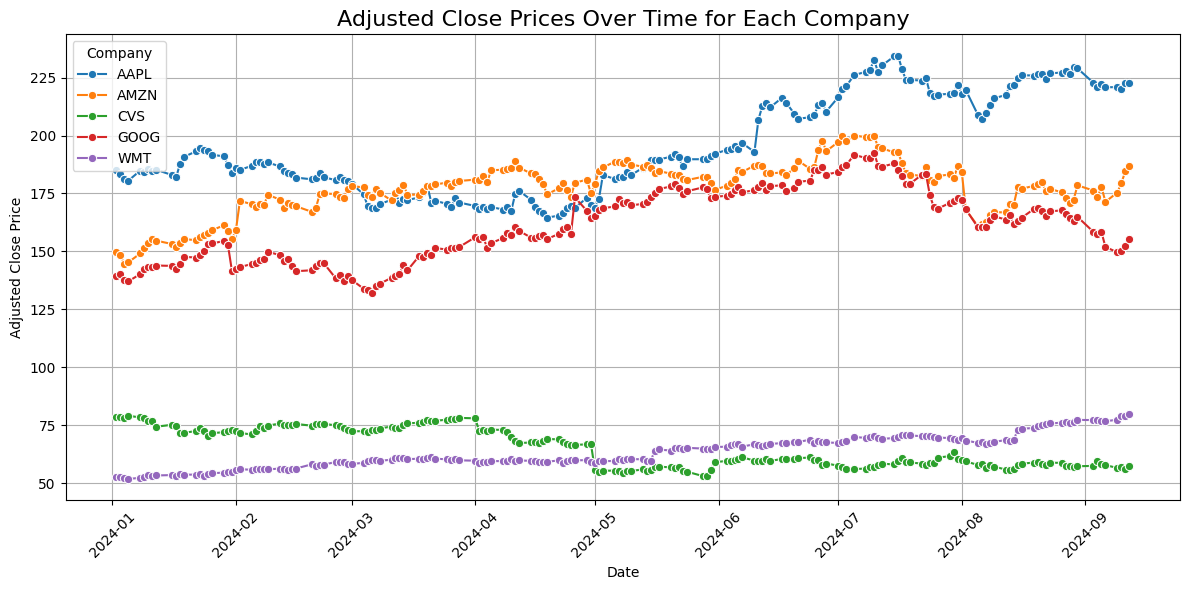

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up a figure
plt.figure(figsize=(12, 6))

# Plot stock price trends
sns.lineplot(x='Date', y='Adj Close', hue='Company', data=df, marker='o')

# Customize the plot
plt.title('Adjusted Close Prices Over Time for Each Company', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.xticks(rotation=45)
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

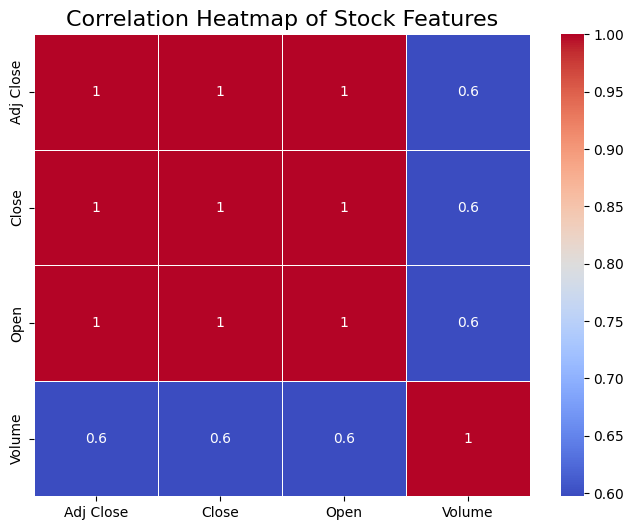

In [20]:
# Correlation matrix
corr_matrix = df[['Adj Close', 'Close', 'Open', 'Volume']].corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Customize the plot
plt.title('Correlation Heatmap of Stock Features', fontsize=16)

# Show plot
plt.show()

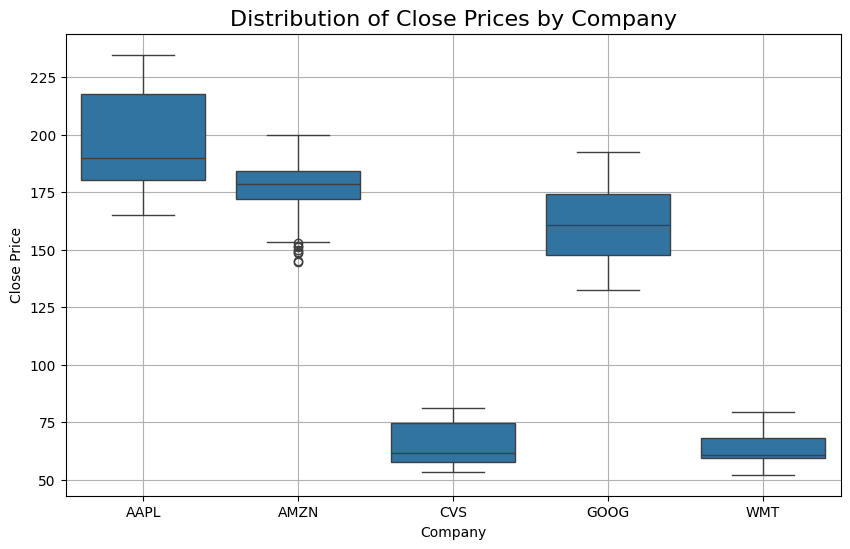

In [21]:
plt.figure(figsize=(10, 6))

# Boxplot for stock close prices
sns.boxplot(x='Company', y='Close', data=df)

# Customize the plot
plt.title('Distribution of Close Prices by Company', fontsize=16)
plt.xlabel('Company')
plt.ylabel('Close Price')
plt.grid(True)

# Show plot
plt.show()

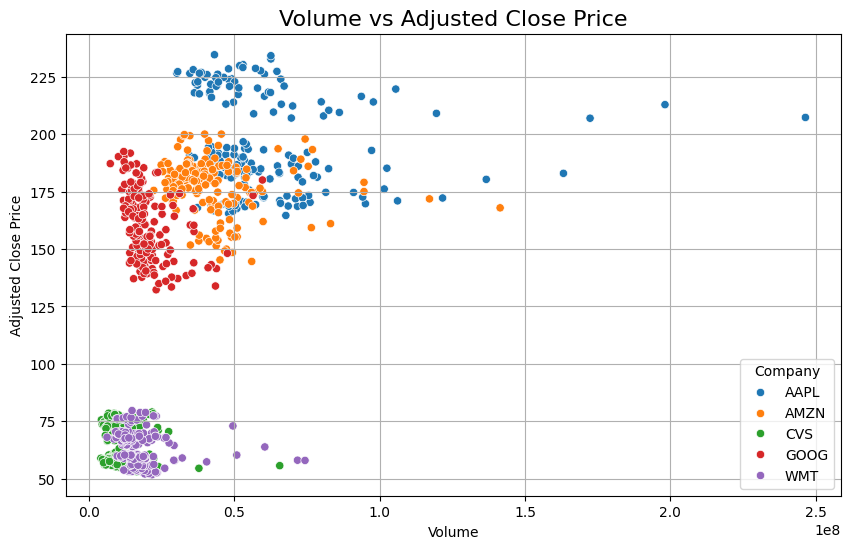

In [22]:
plt.figure(figsize=(10, 6))

# Scatter plot for volume vs adj close
sns.scatterplot(x='Volume', y='Adj Close', hue='Company', data=df)

# Customize the plot
plt.title('Volume vs Adjusted Close Price', fontsize=16)
plt.xlabel('Volume')
plt.ylabel('Adjusted Close Price')
plt.grid(True)

# Show plot
plt.show()

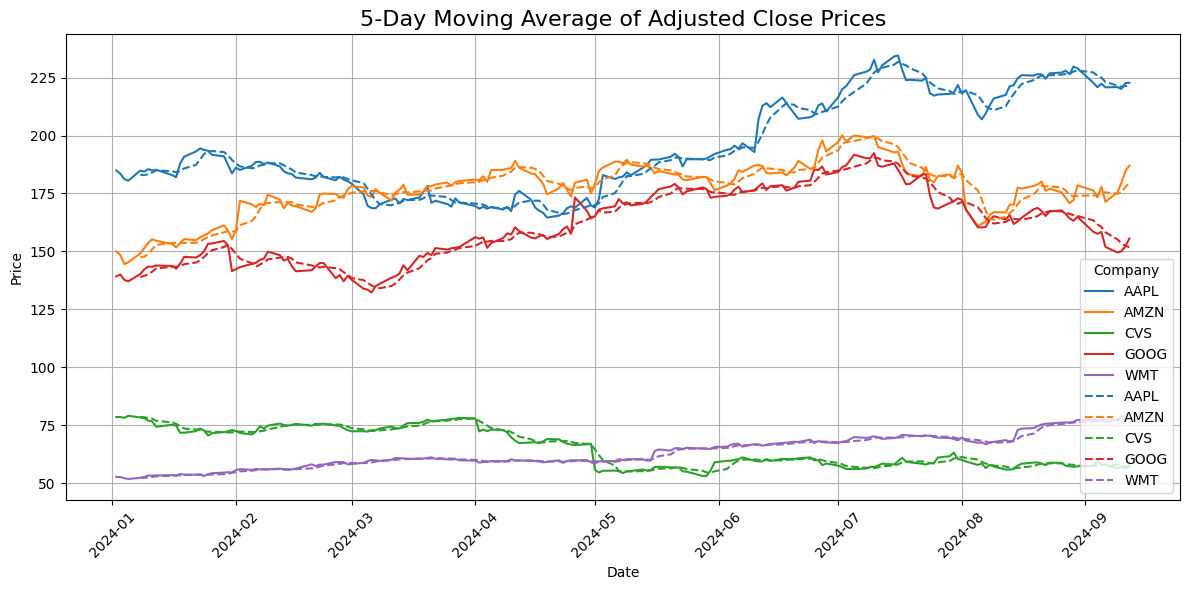

In [27]:
# Calculate the moving average (e.g., 5 days) for AAPL
df['MA_5'] = df.groupby('Company')['Adj Close'].rolling(window=5).mean().reset_index(0, drop=True)

plt.figure(figsize=(12, 6))

# Plot the moving average along with the adjusted close price
sns.lineplot(x='Date', y='Adj Close', hue='Company', data=df)
sns.lineplot(x='Date', y='MA_5', hue='Company', data=df, linestyle='--')

# Customize the plot
plt.title('5-Day Moving Average of Adjusted Close Prices', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

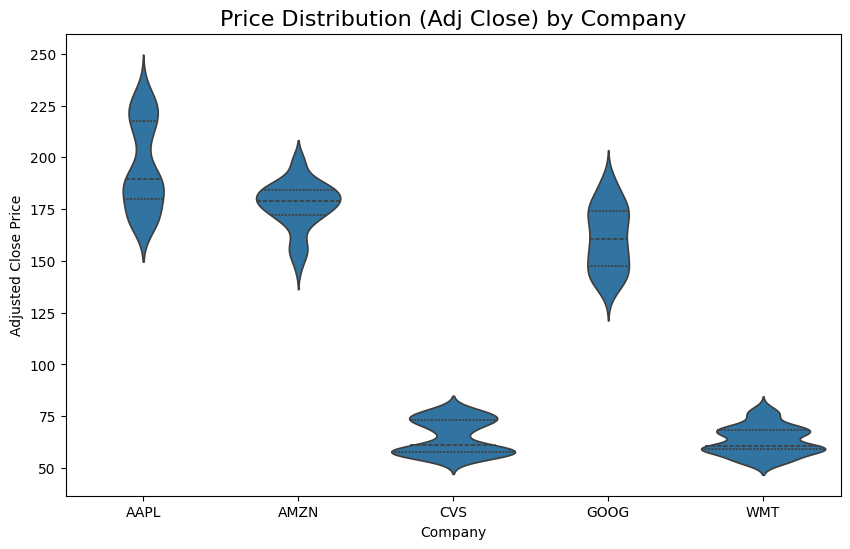

In [28]:
plt.figure(figsize=(10, 6))

# Violin plot for stock close prices
sns.violinplot(x='Company', y='Adj Close', data=df, inner='quartile')

# Customize the plot
plt.title('Price Distribution (Adj Close) by Company', fontsize=16)
plt.xlabel('Company')
plt.ylabel('Adjusted Close Price')

# Show plot
plt.show()